# MRM for Fraud in Finance

In [3]:
# General
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier
#import xgboost as xgb
#from xgboost import XGBClassifier

# Preprocess model
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from category_encoders import TargetEncoder, CountEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE

# Model performance
from sklearn.metrics import (
    confusion_matrix, classification_report, recall_score, precision_score,
    f1_score, precision_recall_curve, roc_auc_score, roc_curve, make_scorer
)

# Explainability
import shap
from lime.lime_tabular import LimeTabularExplainer
from sklearn.inspection import permutation_importance



import logging
import pickle

/Users/efonesca.dos.reis/miniconda3/envs/mrm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [152]:
fig_folder = '../figures/'
# data_folder = '/data_clear/elohim/ccf/TabFormer'
data_folder = '/Users/efonesca.dos.reis/mrm_fraud/datasets/TabFormer/'

# Define models

In [162]:
model_dict={
    'lr': LogisticRegression(class_weight='balanced', random_state=1),
    'lgbm': LGBMClassifier(objective='binary', is_unbalance=True, random_state=1),
    'mlp': MLPClassifier(random_state=1)
}
model_name={'lr':'LR', 'lgbm':'LightGBM', 'mlp':'MLP'}

# Load data

In [4]:
def load_data(file_name, file_folder):
    df = pd.read_csv(file_folder+file_name)
    return df

In [68]:
data.head()

,transactionTime,year,month,weekday,hour,User,Card,Amount,MerchantName,MerchantCity,MerchantState,Zip,MCC,Error,isFraud,UseChip
9196264,1991-01-02 07:10:00,1991,1,2,7,791,1,68.00,2027553650310142703,Burke,VA,22015.0,5541,NoError,0,0
9196265,1991-01-02 07:17:00,1991,1,2,7,791,1,-68.00,2027553650310142703,Burke,VA,22015.0,5541,NoError,0,0
9196266,1991-01-02 07:21:00,1991,1,2,7,791,1,113.62,2027553650310142703,Burke,VA,22015.0,5541,NoError,0,0
9196267,1991-01-02 17:30:00,1991,1,2,17,791,1,114.73,-7269691894846892021,Burke,VA,22015.0,5411,NoError,0,0
9196268,1991-01-03 09:03:00,1991,1,3,9,791,1,251.71,-3693650930986299431,Burke,VA,22015.0,4814,NoError,0,0


In [38]:
df.transactionTime

0          2008-01-01 00:00:00
1          2008-01-01 00:02:00
2          2008-01-01 00:05:00
3          2008-01-01 00:08:00
4          2008-01-01 00:08:00
                  ...         
1223455    2008-12-31 23:51:00
1223456    2008-12-31 23:51:00
1223457    2008-12-31 23:54:00
1223458    2008-12-31 23:56:00
1223459    2008-12-31 23:58:00
Name: transactionTime, Length: 1223460, dtype: object

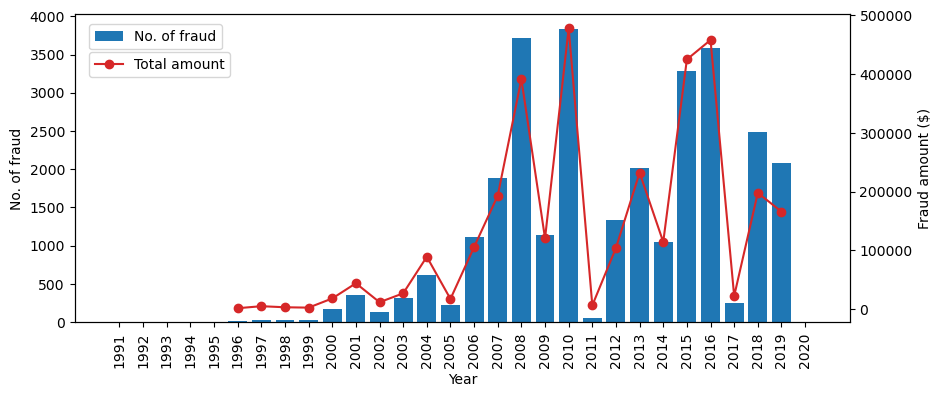

In [121]:
fig, ax = plt.subplots(figsize=(10, 4))

ax2 = ax.twinx()

x = data.groupby('year', as_index=True)['isFraud'].sum()
y = data.loc[data.isFraud == 1].groupby('year')['Amount'].sum()

ax.bar(x.index, x.values, label='No. of fraud')
ax2.plot(y.index, y.values, c='tab:red', marker='o', label='Total amount')
ax.set_xticks(x.index, x.index, rotation=90)
ax.set_xlabel('Year')
ax.set_ylabel('No. of fraud')
ax2.set_ylabel('Fraud amount ($)')
ax.legend(loc='upper left', bbox_to_anchor=(0.01, 0.99))
ax2.legend(loc='upper left', bbox_to_anchor=(0.01, 0.9))

plt.show()

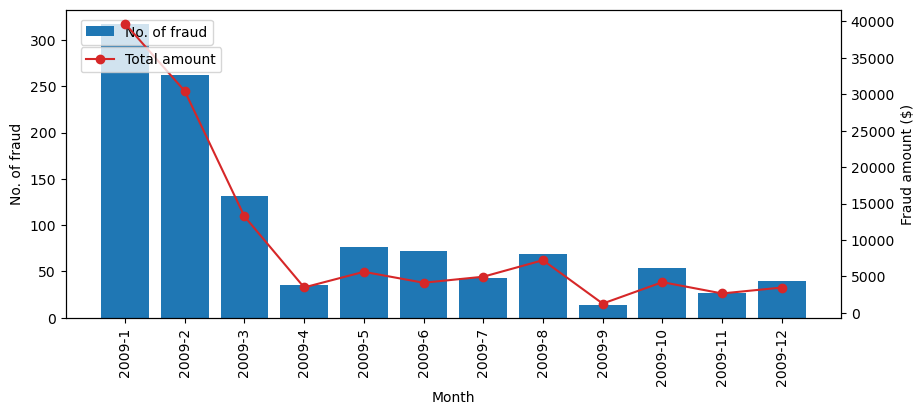

In [26]:
fig, ax = plt.subplots(figsize=(10, 4))

ax2 = ax.twinx()

x = data.groupby(['year', 'month'], as_index=True)['isFraud'].sum()
y = data.loc[data.isFraud == 1].groupby(['year', 'month'])['Amount'].sum()

ax.bar(x.index.map(lambda x: f'{x[0]}-{x[1]}'), x.values, label='No. of fraud')
ax2.plot(y.index.map(lambda x: f'{x[0]}-{x[1]}'), y.values, c='tab:red', marker='o', label='Total amount')
ax.set_xticks(x.index.map(lambda x: f'{x[0]}-{x[1]}'), x.index.map(lambda x: f'{x[0]}-{x[1]}'), rotation=90)
ax.set_xlabel('Month')
ax.set_ylabel('No. of fraud')
ax2.set_ylabel('Fraud amount ($)')
ax.legend(loc='upper left', bbox_to_anchor=(0.01, 0.99))
ax2.legend(loc='upper left', bbox_to_anchor=(0.01, 0.9))

plt.show()

# Preprocess data

In [5]:
# --- Preprocessing raw data ---
def preprocess_data(df):
    ''' Preprocess raw data. '''

    # Rename columns
    df.rename(columns={'Merchant Name':'MerchantName', 
                       'Merchant City':'MerchantCity', 
                       'Is Fraud?':'isFraud', 
                       'Merchant State':'MerchantState',
                       'Errors?':'Error'
                      },
              inplace=True
             )
    
    # Convert 'Amount' to fload
    df.Amount = df.Amount.str[1:].astype(float)

    # Convert 'UseChip' to numeric 'merchantNum'
    UseChipStr_to_UseChipNum = {UseChipStr:UseChipNum for UseChipNum, UseChipStr in enumerate(df['Use Chip'].unique())}
    df['UseChip'] = df['Use Chip'].map(UseChipStr_to_UseChipNum)
    df.drop('Use Chip', axis=1, inplace=True)
    
    # Replace fraud flags by 0 and 1
    df.isFraud = df.isFraud.replace({'No':0, 'Yes':1}).astype(int)
    
    # Join date and time and converto to datetime: transactionTime
    transactionTime = pd.to_datetime(df.Year.astype(str) + '-' 
                                     + df.Month.astype(str) + '-' 
                                     + df.Day.astype(str) + ' ' 
                                     + df.Time.astype(str))
    df.insert(0, 'transactionTime', transactionTime)
    
    # Sort dataframe by transaction time
    df = df.sort_values(by='transactionTime')
    
    # General temporal features
    df.insert(1, 'hour', df['transactionTime'].dt.hour)
    df.insert(1, 'weekday', df['transactionTime'].dt.dayofweek)
    df.insert(1, 'month', df['transactionTime'].dt.month)
    df.insert(1, 'year', df['transactionTime'].dt.year)
    
    df.drop(['Year', 'Month', 'Day', 'Time'], axis=1, inplace=True)
    
    # Imput a value for missing values
    df.MerchantState = df.MerchantState.fillna('Missing')
    df.Zip = df.Zip.fillna(0)
    # No error variable
    df.Error = df.Error.fillna('NoError')

    return df

# Define features

In [33]:
# Rolling time window for user lever patterns
time_window='7D'

# --- Predictors

# Numerical variables
num_vars = ['Amount', 
            # 'userTxMean',
            # 'userTxMedian',
            # 'userTxStd',
            # 'userTxMax',
            # 'userTxMin',
            # 'userTxFreq',
            # 'userMerchant',
            # 'userMCC',
            # 'userCity',
            # 'userState',
            # 'userZip'
           ]
# Frequency encoding variables
freq_enc_vars = ['hour']# + ['MerchantName', 'MerchantCity',  'MerchantState', 'Zip', 'MCC'] + ['weekday', 'UseChip']
# Target encoding variables
target_enc_vars = ['MerchantName', 'MerchantCity',  'MerchantState', 'Zip', 'MCC']
# One-hot encoding variables
onehot_enc_vars = ['weekday', 'UseChip']
# List of predictors
var_cols = num_vars+freq_enc_vars+target_enc_vars+onehot_enc_vars

# Logging configuration
# logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Feature engineering

In [35]:
df.head()

,transactionTime,year,month,weekday,hour,User,Card,Amount,UseChip,MerchantName,MerchantCity,MerchantState,Zip,MCC,Error,isFraud,MerchantCityNum,MerchantStateNum
0,2008-01-01 00:00:00,2008,1,1,0,1911,4,19.23,0,5232322915998164853,Kissimmee,FL,34746.0,5813,NoError,0,0,0
1,2008-01-01 00:02:00,2008,1,1,0,583,2,97.29,0,3467663023930633227,Houston,TX,77047.0,5912,NoError,0,1,1
2,2008-01-01 00:05:00,2008,1,1,0,34,1,2.72,0,-4500542936415012428,Mobile,AL,36693.0,5814,NoError,0,2,2
3,2008-01-01 00:08:00,2008,1,1,0,928,2,160.00,0,-4282466774399734331,South Hill,VA,23970.0,4829,NoError,0,3,3
4,2008-01-01 00:08:00,2008,1,1,0,1497,2,140.00,0,-4282466774399734331,Crown Point,IN,46307.0,4829,NoError,0,4,4


In [36]:
df.head().rolling(time_window, on='transactionTime')['Amount'].mean()

ValueError: window must be an integer 0 or greater

In [31]:
# --- Feature engineering ---

def convert_to_numeric(df, feature):
    featureStr_to_featureNum = {iStr:iNum for iNum, iStr in enumerate(df[feature].unique())}
    return df[feature].map(featureStr_to_featureNum)
    
def feature_engineering(df):
    ''' Create new variables from data variables. '''

    # Convert 'MerchantCity' to numeric 'MerchantCityNum'
    df['MerchantCityNum'] = convert_to_numeric(df, 'MerchantCity')

    # Convert 'MerchantState' to numeric 'MerchantStateNum'
    df['MerchantStateNum'] = convert_to_numeric(df, 'MerchantState')

    # User level patterns
    dfnew = pd.DataFrame()
    for _ , gdata in df.groupby('User'):
        
        # Transaction patterns
        gdata['userTxMean'] = gdata.rolling(time_window, on='transactionTime')['Amount'].mean()
        gdata['userTxMedian'] = gdata.rolling(time_window, on='transactionTime')['Amount'].median()
        gdata['userTxStd'] = gdata.rolling(time_window, on='transactionTime')['Amount'].std().fillna(0)
        gdata['userTxMax'] = gdata.rolling(time_window, on='transactionTime')['Amount'].max()
        gdata['userTxMin'] = gdata.rolling(time_window, on='transactionTime')['Amount'].min()
        gdata['userTxFreq'] = gdata.rolling(time_window, on='transactionTime')['Amount'].count()
    
        # Merchant patterns
        gdata['userMerchant'] = gdata.rolling(time_window, on='transactionTime')['MerchantName'].apply(lambda x: x.nunique())
        gdata['userMCC'] = gdata.rolling(time_window, on='transactionTime')['MCC'].apply(lambda x: x.nunique())
    
        # Geographical patterns
        gdata['userCity'] = gdata.rolling(time_window, on='transactionTime')['MerchantCityNum'].apply(lambda x: x.nunique())
        gdata['userState'] = gdata.rolling(time_window, on='transactionTime')['MerchantStateNum'].apply(lambda x: x.nunique())
        gdata['userZip'] = gdata.rolling(time_window, on='transactionTime')['Zip'].apply(lambda x: x.nunique())
        
        dfnew = pd.concat([dfnew, gdata])
    df = dfnew.sort_values(by='transactionTime')

    return df


# Encoding/Scaling

In [7]:
# --- Encoding/Scaling ---
def onehot_transform(df, ohe_vars):
    ''' One-hot encoder. '''
    # Define one-hot encoder
    onehot_encoder = OneHotEncoder(sparse_output=False)
    
    # Fit-transform variables
    df_onehot = pd.DataFrame(onehot_encoder.fit_transform(df[ohe_vars].astype('str')))
    df_onehot.columns = onehot_encoder.get_feature_names_out()
    df_onehot.index = df.index
    
    # Remove original categorical variables
    df.drop(ohe_vars, axis=1, inplace=True)
    
    # Concatenate data set with one-hot columns
    df = pd.concat([df, df_onehot], axis=1)
    return df
def encode_scale_data(X_train, X_test, y_train, num_vars, target_enc_vars, freq_enc_vars, onehot_enc_vars):
    ''' Encode and scale data. '''
    pd.set_option('future.no_silent_downcasting', True)
    
    # Target encoding
    if target_enc_vars:
        target_encoder = TargetEncoder(cols=target_enc_vars)
        X_train = target_encoder.fit_transform(X_train, y_train)
        X_test = target_encoder.transform(X_test)
    
    # Frequency encoding
    if freq_enc_vars:
        freq_encoder = CountEncoder(cols=freq_enc_vars)
        X_train = freq_encoder.fit_transform(X_train, y_train)
        X_test = freq_encoder.transform(X_test)
    
    # Scaling
    scaler = StandardScaler(with_mean=True, with_std=True).set_output(transform="pandas")
    scale_cols = num_vars+target_enc_vars+freq_enc_vars
    scaler.fit(X_train[scale_cols])
    X_train = pd.concat([X_train.drop(scale_cols, axis=1), scaler.transform(X_train[scale_cols])], axis=1)
    X_test = pd.concat([X_test.drop(scale_cols, axis=1), scaler.transform(X_test[scale_cols])], axis=1)
    
    # One-hot encoding
    if onehot_enc_vars:
        X_train = onehot_transform(X_train, onehot_enc_vars)
        X_test = onehot_transform(X_test, onehot_enc_vars)

    return X_train, X_test

# Collinearity

In [47]:
# --- Collinearity ---
def remove_collinearity(X_train, X_test, num_vars, target_enc_vars, freq_enc_vars):
    ''' Remove high collinearity with VIF > 10. '''

    # Select columns
    vif_cols = num_vars+target_enc_vars+freq_enc_vars
    
    vif_removed_cols=[]
    while True:
        X_train_values = X_train[vif_cols].values
        
        # Variance Inflation Factor
        vif = pd.DataFrame()
        vif['Variable'] = vif_cols
        vif['VIF'] = [variance_inflation_factor(X_train_values, i) for i in range(X_train_values.shape[1])]
        vif = vif[vif.VIF > 10].sort_values(by='VIF', ascending=False)
        if vif.empty:
            break
    
        # Remove column with highest VIF (>10)
        vif_removed_cols.append(vif.iloc[0,0])
        X_train.drop(vif.iloc[0,0], axis=1, inplace=True)
        X_test.drop(vif.iloc[0,0], axis=1, inplace=True)
        vif_cols.remove(vif.iloc[0,0])
        logging.info(f'Remove column {vif.iloc[0,0]} with VIF = {vif.iloc[0,1]}')
        
    return X_train, X_test, vif_removed_cols

# Training model

In [8]:
def model_training(X_train_set, y_train_target, model):
    ''' Training the model.
        Models tested: Logistic Regression, Random Forest, LightLGB
    '''

    model.fit(X_train_set, y_train_target.values.ravel())

    return model

# Evaluate model

In [9]:
def evaluate_model(model, X_test, y_test):
    ''' Evaluate the model and return metrics obtained. '''
    
    # Model predictions
    pred = model.predict(X_test)
    # Prediction probabilities
    pred_prob = model.predict_proba(X_test)[:, 1]
    
    # Metrics
    metrics = {
        'confusion_matrix': confusion_matrix(y_test, pred),
        'classification_report': classification_report(y_test, pred),
        'recall_score': recall_score(y_test, pred),
        'precision_score': precision_score(y_test, pred),
        'f1_score': f1_score(y_test, pred),
        'precision_recall_curve': precision_recall_curve(y_test, pred_prob),
        'roc_auc_score': roc_auc_score(y_test, pred_prob),
        'roc_curve': roc_curve(y_test, pred_prob)
    }

    return metrics

In [10]:
# --- Precision recall curve ---
def plot_precision_recall_curve(model_pr_curve, color='C0', lw=2, marker=None, ax=None, 
                                title_fs=12, axis_label_fs=12, axis_tick_fs=12):
    ''' Plot the precision-recall curve.'''
    # Compute the precision, recall and threshold
    precision, recall, thresholds = model_pr_curve
    
    # fig, ax = plt.subplots(figsize=(4.5, 4))
    if ax is None:
        ax = plt.gca()
    
    # Plot the curve
    ax.plot([0, 1], [0, 1], color='k', linestyle='--', lw=1)  # Plot the diagonal line (random classifier)
    ax.plot(recall, precision, color=color, marker=marker, lw=lw)
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('Recall', fontsize=axis_label_fs)
    ax.set_ylabel('Precision', fontsize=axis_label_fs)
    ax.set_title('Precision-Recall Curve', fontsize=title_fs)
    ax.tick_params(labelsize=axis_tick_fs)
    ax.grid(True)

    plt.tight_layout()
    # plt.show()
    # plt.savefig('precision_recall_curve.png', dpi=500, bbox_inches='tight')

In [11]:
# Plot the ROC curve
def plot_roc_curve(model_roc_curve, model_roc_auc, color='C0', model_name=None, ax=None, 
                   lw=2, title_fs=12, axis_label_fs=12, legend_fs=10, axis_tick_fs=12):
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = model_roc_curve
    roc_auc = model_roc_auc

    # fig, ax = plt.subplots(figsize=(4.5, 4))
    if ax is None:
        ax = plt.gca()

    ax.plot([0, 1], [0, 1], color='k', linestyle='--', lw=1)  # Plot the diagonal line (random classifier)
    ax.plot(fpr, tpr, color=color, lw=lw, label=f'{model_name} (AUC = {roc_auc:.2f})')
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate (FPR)', fontsize=axis_label_fs)
    ax.set_ylabel('True Positive Rate (TPR)', fontsize=axis_label_fs)
    ax.set_title('ROC Curve', fontsize=title_fs)
    ax.legend(loc='lower right', fontsize=legend_fs)
    ax.tick_params(labelsize=axis_tick_fs)
    ax.grid(True)
    # plt.show()


# main()

In [ ]:
# --- main() function --- 
# def main(transaction_file):

In [8]:
# # Data Folder
# data_folder = '/Users/efonesca.dos.reis/mrm_fraud/datasets/TabFormer/'
# # data_folder = '/data_clear/elohim/ccf/TabFormer/'
# # File
# file_name = 'card_transaction.v1.csv'

In [341]:
%%time
# Load data
df = pd.DataFrame()
for year in [2001]:
    df = pd.concat([df, load_data('card_transaction.v1-'+str(year)+'.csv', data_folder)])
# Convert transaction time to datetime
df.transactionTime = pd.to_datetime(df.transactionTime)

CPU times: user 228 ms, sys: 46.9 ms, total: 275 ms
Wall time: 281 ms


In [15]:
%%time
# Preprocess data
# df = preprocess_data(df)

CPU times: user 6 μs, sys: 3 μs, total: 9 μs
Wall time: 15.3 μs


In [76]:
%%time
# Feature engineering
# df = feature_engineering(df)

CPU times: user 25.7 s, sys: 458 ms, total: 26.2 s
Wall time: 26.2 s


In [342]:
# Split data into Train/Test sets
X, y = df[var_cols], df['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [343]:
%%time
# Encode and scale data
X_train, X_test = encode_scale_data(X_train, X_test, y_train, num_vars, target_enc_vars, freq_enc_vars, onehot_enc_vars)

CPU times: user 606 ms, sys: 137 ms, total: 743 ms
Wall time: 744 ms


In [208]:
%%time
# Remove collinearity with VIF
X_train, X_test, vif_removed_cols = remove_collinearity(X_train, X_test, num_vars, target_enc_vars, freq_enc_vars)
logging.info(f'Removed columns due to collinearity: {vif_removed_cols}')

CPU times: user 1.82 s, sys: 1.06 s, total: 2.88 s
Wall time: 358 ms


In [344]:
# Class imbalance: oversample with SMOTE to treat class imbalance
smote = SMOTE(sampling_strategy='auto', random_state=1)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [259]:
# Train model

In [345]:
model_dict={}
model_dict['lr'] = LogisticRegression(class_weight='balanced', random_state=1)
# model_dict['rf'] = RandomForestClassifier(n_jobs=5, 
#                                       random_state=1,
#                                       criterion='log_loss',
#                                       class_weight='balanced',
#                                       verbose=False)
model_dict['lgbm'] = LGBMClassifier(objective='binary', is_unbalance=True, random_state=1)
model_dict['mlp'] = MLPClassifier(random_state=1)

model_name={'lr':'LR', 'lgbm':'LightGBM', 'mlp':'MLP'}

In [346]:
%%time
model=dict()
metrics=dict()
for m in model_dict:
    print(m)
    model[m] = model_training(X_train, y_train, model_dict[m])
    metrics[m] = evaluate_model(model[m], X_test, y_test)
    print('ok')

lr
ok
lgbm
[LightGBM] [Info] Number of positive: 206095, number of negative: 206095
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3069
[LightGBM] [Info] Number of data points in the train set: 412190, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
ok
mlp
ok
CPU times: user 3min 59s, sys: 11.7 s, total: 4min 11s
Wall time: 26.1 s


In [ ]:
# --- MISSING ---
    # # Cross-validation
    # cross_validation(model, X_train_smote, y_train_smote)

In [ ]:

    # # Compute probabilites for all data transactions
    # df_all_pred_prob = all_transactions_pred_prob(model, X, y, df, vif_removed_cols, num_vars, target_enc_vars, freq_enc_vars, onehot_enc_vars)

    # # Plot figures
    # plot_feature_importance(model)
    # plot_precision_recall_curve(y_test, pred_prob)
    # plot_review_load(df_all_pred_prob, y_test, pred_prob)

    # return model, metrics

# Model performance

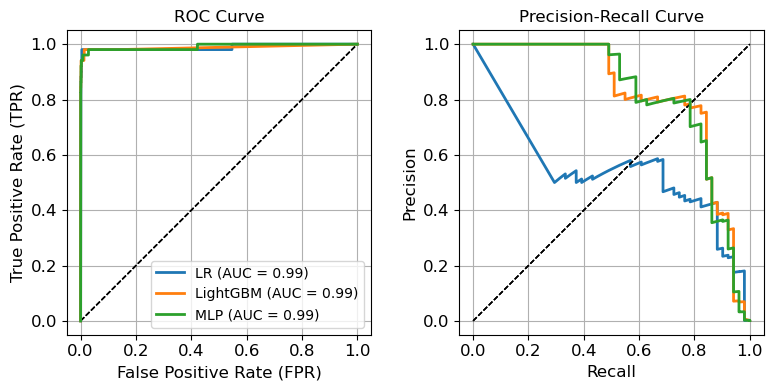

In [347]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))


for i, m in enumerate(model_dict.keys()):
    # ROC curve
    plot_roc_curve(metrics[m]['roc_curve'], metrics[m]['roc_auc_score'], model_name=model_name[m], color='C'+str(i), ax=ax[0])
    # PR curve
    plot_precision_recall_curve(metrics[m]['precision_recall_curve'], color='C'+str(i), ax=ax[1])

ax[0].set_aspect('equal')
ax[1].set_aspect('equal')

plt.savefig(fig_folder+'roc_pr_curve.png', dpi=300)
plt.show()

In [348]:
models_metrics=[]
for m in model_dict:
    models_metrics.append([metrics[m]['precision_score'], 
                           metrics[m]['recall_score'], 
                           metrics[m]['f1_score'], 
                           metrics[m]['roc_auc_score']])

pd.DataFrame(models_metrics, columns=['Precision', 'Recall', 'F1', 'ROC-AUC'], index=['LR', 'LGBM', 'MLP']).round(2).T

,LR,LGBM,MLP
Precision,0.13,0.73,0.62
Recall,0.98,0.84,0.84
F1,0.23,0.78,0.72
ROC-AUC,0.99,0.99,0.99


In [349]:
print(pd.DataFrame(models_metrics, columns=['Precision', 'Recall', 'F1', 'ROC-AUC'], index=['LR', 'LGBM', 'MLP']).round(2).T.to_latex())

\begin{tabular}{lrrr}
\toprule
 & LR & LGBM & MLP \\
\midrule
Precision & 0.130000 & 0.730000 & 0.620000 \\
Recall & 0.980000 & 0.840000 & 0.840000 \\
F1 & 0.230000 & 0.780000 & 0.720000 \\
ROC-AUC & 0.990000 & 0.990000 & 0.990000 \\
\bottomrule
\end{tabular}



# Explainability

## SHAP

In [169]:
%%time
shap_values={}
explainer={}
for m in model_dict.keys():
    print(m)
    
    if m == 'mlp':
        pass
        # # Create SHAP Explainer for model
        # X_train_kmeans = shap.kmeans(X_train, 100) # Summarize train set with k mean samples
        # explainer = shap.KernelExplainer(model[m].predict, X_train_kmeans)
        # # Calculate SHAP values
        # shap_values[m] = explainer(X_test)
    else:
        # Create SHAP Explainer for model
        explainer[m] = shap.Explainer(model[m], X_train)
        # Calculate SHAP values
        shap_values[m] = explainer[m](X_test)
        
    print('ok')

lr
ok
lgbm


100%|===================| 51532/51600 [00:50<00:00]        

ok
mlp
ok
CPU times: user 50.5 s, sys: 190 ms, total: 50.7 s
Wall time: 50.7 s


In [170]:
lr_featImportance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficients': model['lr'].coef_[0]
}).sort_values(by='Coefficients', ascending=True)

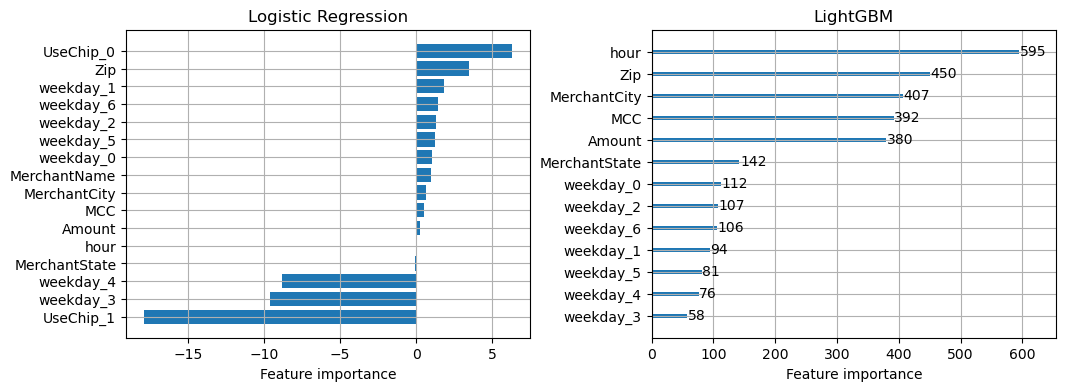

In [171]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].barh(lr_featImportance.Feature, lr_featImportance.Coefficients)
ax[0].set_title('Logistic Regression')
ax[0].set_xlabel('Feature importance')
ax[0].grid()

lgb.plot_importance(model_dict['lgbm'], importance_type='auto', ax=ax[1])
ax[1].set_ylabel('')
ax[1].set_title('LightGBM')

plt.subplots_adjust(wspace=0.3)

lr
lgbm


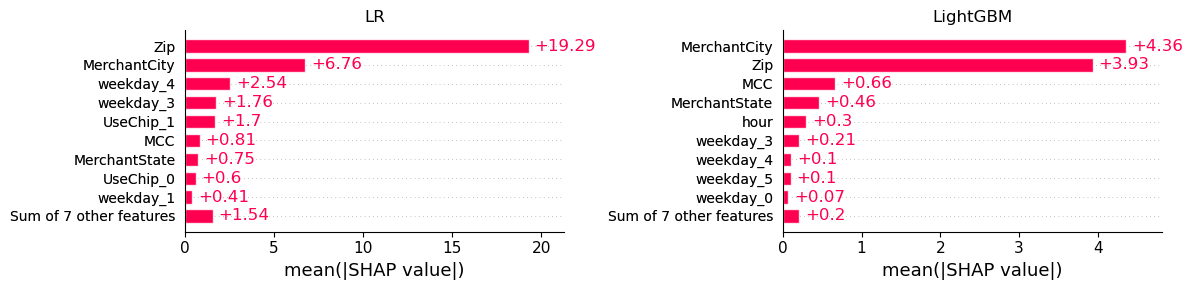

In [172]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))

# plt.figure()
for i, m in enumerate(model_dict.keys()):
    if m == 'mlp':
        pass
    else:
        print(m)
        # plt.subplot(1, 2, i+1)
        shap.plots.bar(shap_values[m], ax=ax[i], show=False)
        # plt.xlabel_format(fontsize=10)
        ax[i].set_title(model_name[m])
        ax[i].tick_params(axis='y', which='major', labelsize=10)
plt.tight_layout()
plt.show()

lr
lgbm


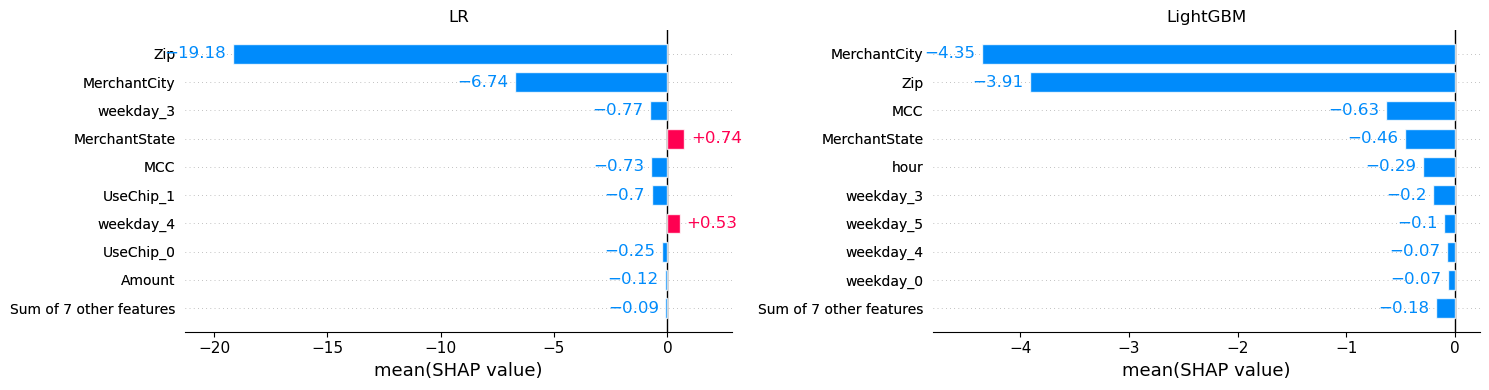

In [174]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))


# plt.figure()
for i, m in enumerate(model_dict.keys()):
    if m == 'mlp':
        pass
    else:
        print(m)
        # plt.subplot(1, 2, i+1)
        # shap.plots.bar(shap_values[m].min(0), ax=ax[i], show=False)
        # shap.plots.bar(shap_values[m].max(0), ax=ax[i], show=False)
        # shap.plots.bar(shap_values[m].abs.mean(0), ax=ax[i], show=False)
        shap.plots.bar(shap_values[m].mean(0), ax=ax[i], show=False)
        # plt.xlabel_format(fontsize=10)
        ax[i].set_title(model_name[m])
        ax[i].tick_params(axis='y', which='major', labelsize=10)
plt.tight_layout()
plt.show()

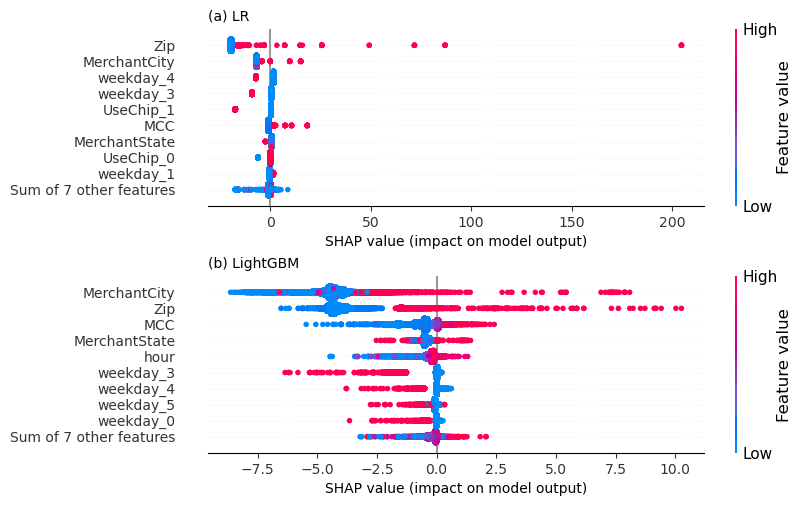

In [350]:
plt.figure(figsize=(12, 10))

title={0:'(a) ', 1:'(b) '}
for i, m in enumerate(['lr', 'lgbm']):
    plt.subplot(2, 1, i+1)
    shap.plots.beeswarm(shap_values[m], show=False)
    plt.title(title[i]+model_name[m], loc='left', fontsize=10)
    plt.tick_params(axis='both', labelsize=10)
    plt.gca().xaxis.label.set_size(10)
plt.subplots_adjust(hspace=0.4)
plt.savefig(fig_folder+'shap_values.png', dpi=300, bbox_inches='tight')
plt.show()

## Permutation Importance

In [176]:
%%time
perm_imp={}
scoring = ['recall', 'precision']
for m in ['lr', 'lgbm', 'mlp']:
    perm_imp[m] = permutation_importance(model_dict[m], X_test, y_test, 
                                         scoring=scoring,
                                         n_repeats=30, 
                                         max_samples=1.0, 
                                         random_state=1)


CPU times: user 4min 10s, sys: 2min 51s, total: 7min 1s
Wall time: 44.4 s


In [177]:
%%time
perm_imp_train={}
scoring = ['recall', 'precision']
for m in ['lr', 'lgbm', 'mlp']:
    perm_imp_train[m] = permutation_importance(model_dict[m], X_train, y_train, 
                                                 scoring=scoring,
                                                 n_repeats=30, 
                                                 max_samples=1.0, 
                                                 random_state=1)


CPU times: user 29min 43s, sys: 31min 13s, total: 1h 57s
Wall time: 6min 41s


In [126]:
def plot_perm_imp(perm_imp, ax=None, model_name=None):

    sorted_importances_idx = perm_imp.importances_mean.argsort()
    importances = pd.DataFrame(
        perm_imp.importances[sorted_importances_idx].T,
        columns=X_test.columns[sorted_importances_idx],
    )
    importances.plot.box(vert=False, whis=10, ax=ax)
    ax.axvline(x=0, color="k", linestyle="--")

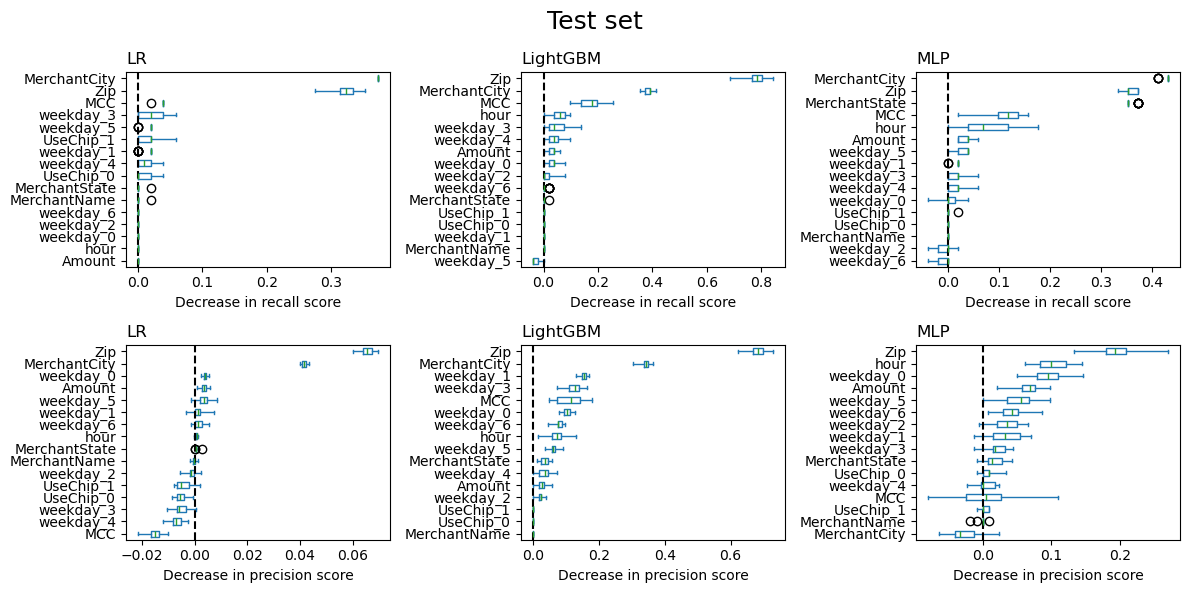

In [191]:
fig, ax = plt.subplots(len(scoring), len(perm_imp.keys()), figsize=(12, 6))

for j, m in enumerate(['lr', 'lgbm', 'mlp']):
    for i, metric in enumerate(scoring):
        plot_perm_imp(perm_imp[m][metric], model_name=model_name[m], ax=ax[i, j])
        ax[i,j].set_title(model_name[m], loc='left')
        ax[i,j].set_xlabel('Decrease in '+metric+' score')
        # ax[i,j].figure.tight_layout()
fig.suptitle('Test set', y=0.98, fontsize=18)
plt.tight_layout()
plt.savefig(fig_folder+'permutation_importance_test.png', dpi=300, bbox_inches='tight')
plt.show()

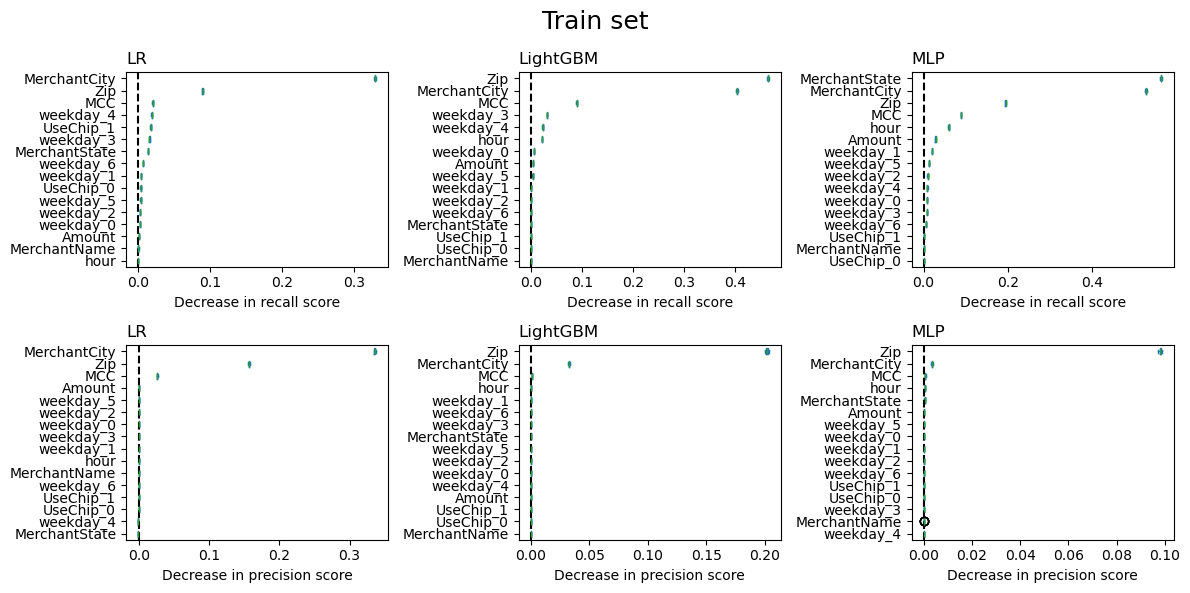

In [190]:
fig, ax = plt.subplots(len(scoring), len(perm_imp_train.keys()), figsize=(12, 6))

for j, m in enumerate(['lr', 'lgbm', 'mlp']):
    for i, metric in enumerate(scoring):
        plot_perm_imp(perm_imp_train[m][metric], model_name=model_name[m], ax=ax[i, j])
        ax[i,j].set_title(model_name[m], loc='left')
        ax[i,j].set_xlabel('Decrease in '+metric+' score')
        # ax[i,j].figure.tight_layout()
fig.suptitle('Train set', y=0.98, fontsize=18)
plt.tight_layout()
plt.savefig(fig_folder+'permutation_importance_train.png', dpi=300, bbox_inches='tight')
plt.show()

In [81]:
for i in permimp.importances_mean.argsort()[::-1]:
    # if permimp.importances_mean[i] - 2 * permimp.importances_std[i] > 0:
    print(f"{X_test.columns[i]:<8}"
          f"\t{permimp.importances_mean[i]:.3f}"
          f" +/- {permimp.importances_std[i]:.3f}")

MerchantCity	0.373 +/- 0.000
Zip     	0.320 +/- 0.025
MCC     	0.039 +/- 0.004
weekday_3	0.025 +/- 0.019
UseChip_1	0.019 +/- 0.017
weekday_5	0.017 +/- 0.006
weekday_1	0.017 +/- 0.007
weekday_4	0.015 +/- 0.018
UseChip_0	0.008 +/- 0.011
MerchantName	0.001 +/- 0.004
MerchantState	0.000 +/- 0.003
weekday_6	0.000 +/- 0.000
weekday_2	0.000 +/- 0.000
weekday_0	0.000 +/- 0.000
hour    	0.000 +/- 0.000
Amount  	0.000 +/- 0.000


## LIME

# Robustness

# main()

In [298]:
%%time

def eval_robustness_perform(years=None, models=None):
    metrics = {m:[] for m in models}
    # Data shift - model performance
    for year in years:
        print(year)
        df = load_data('card_transaction.v1-'+str(year)+'.csv', data_folder)
        # Convert transaction time to datetime
        df.transactionTime = pd.to_datetime(df.transactionTime)
    
        # Split data into Train/Test sets
        X, y = df[var_cols], df['isFraud']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
        # Encode and scale data
        X_train, X_test = encode_scale_data(X_train, X_test, y_train, num_vars, target_enc_vars, freq_enc_vars, onehot_enc_vars)
    
        # Class imbalance: oversample with SMOTE to treat class imbalance
        smote = SMOTE(sampling_strategy='auto', random_state=1)
        X_train, y_train = smote.fit_resample(X_train, y_train)
    
        # Train and evaluate models
        # model=dict()
        for m in models:#model_dict:
            print(m)
            # Train
            model = model_training(X_train, y_train, model_dict[m])
            # # Evaluate
            # robustness_metrics[m][year] = evaluate_model(model, X_test, y_test)
    
            # Model predictions
            pred = model.predict(X_test)
            
            # Metrics
            metrics[m].append([year, 
                               recall_score(y_test, pred), 
                               precision_score(y_test, pred),
                               f1_score(y_test, pred)
                              ])
            
            print('ok')
        print('year ok\n')
    
    for m in models:
        df = pd.DataFrame(metrics[m], columns=['year', 'recall', 'precision', 'f1'])
        df['year'] = df['year'].astype(str)
        metrics[m] = df
    
    return metrics
    

CPU times: user 5 μs, sys: 2 μs, total: 7 μs
Wall time: 10.7 μs


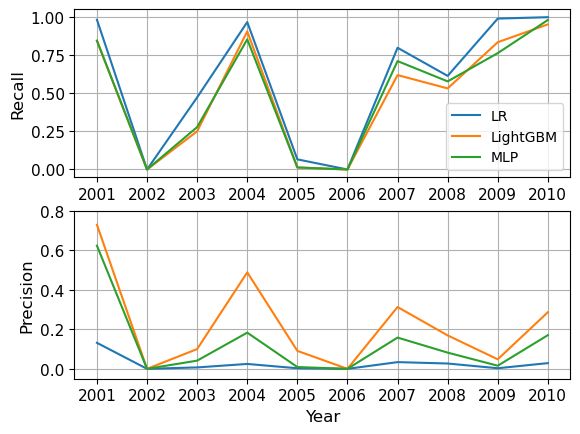

In [351]:
axis_label_fs = 12
axis_tick_fs = 11
legend_fs = 10

fig, ax = plt.subplots(2, 1)
for m in models:
    y = robust_perfm[m].year
    rec = robust_perfm[m].recall
    prec = robust_perfm[m].precision

    # Recall
    ax[0].plot(y, rec, label=model_name[m])

    # Precision
    ax[1].plot(y, prec)

ax[0].legend(fontsize=legend_fs)
ax[0].set_ylim(bottom=-0.05, top=1.05)
ax[0].set_ylabel('Recall', fontsize=axis_label_fs)
ax[0].tick_params(labelsize=axis_tick_fs)
ax[0].grid()

ax[1].set_ylim(top=0.8, bottom=-0.05)
ax[1].set_ylabel('Precision', fontsize=axis_label_fs)
ax[1].set_xlabel('Year', fontsize=axis_label_fs)
ax[1].tick_params(labelsize=axis_tick_fs)
ax[1].grid()

plt.show()

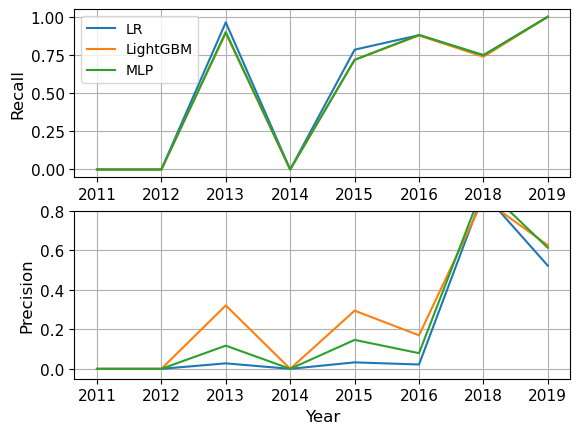

In [352]:
axis_label_fs = 12
axis_tick_fs = 11
legend_fs = 10

fig, ax = plt.subplots(2, 1)
for m in models:
    y = robust_perfm2[m].year
    rec = robust_perfm2[m].recall
    prec = robust_perfm2[m].precision

    # Recall
    ax[0].plot(y, rec, label=model_name[m])

    # Precision
    ax[1].plot(y, prec)

ax[0].legend(fontsize=legend_fs)
ax[0].set_ylim(bottom=-0.05, top=1.05)
ax[0].set_ylabel('Recall', fontsize=axis_label_fs)
ax[0].tick_params(labelsize=axis_tick_fs)
ax[0].grid()

ax[1].set_ylim(top=0.8, bottom=-0.05)
ax[1].set_ylabel('Precision', fontsize=axis_label_fs)
ax[1].set_xlabel('Year', fontsize=axis_label_fs)
ax[1].tick_params(labelsize=axis_tick_fs)
ax[1].grid()

plt.show()

In [354]:
robust_perfm['lr']

,year,recall,precision
0,2001,0.980392,0.131579
1,2002,0.000000,0.000000
2,2003,0.472222,0.007234
3,2004,0.965217,0.024777
4,2005,0.066225,0.002987
5,2006,0.000000,0.000000
6,2007,0.796992,0.034007
7,2008,0.612795,0.026948
8,2009,0.988095,0.003066
9,2010,0.997147,0.028927


In [355]:
robust_perfm2['lr']

,year,recall,precision
0,2011,0.000000,0.000000
1,2012,0.000000,0.000000
2,2013,0.963415,0.027766
3,2014,0.000000,0.000000
4,2015,0.784383,0.032764
5,2016,0.879371,0.021975
6,2018,0.748333,0.889109
7,2019,1.000000,0.521739


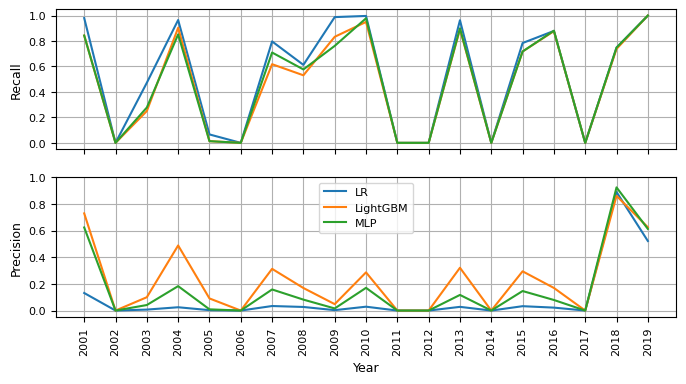

In [376]:
axis_label_fs = 9
axis_tick_fs = 8
legend_fs = 8
title_fs = 9

fig, ax = plt.subplots(2, 1, figsize=(8, 4))
for m in models:
    df = pd.concat([robust_perfm[m], robust_perfm2[m]])
    df = pd.concat([df, pd.DataFrame([['2017', 0, 0]], columns=df.columns)]).sort_values(by='year')
    y = df.year
    rec = df.recall
    prec = df.precision

    # Recall
    ax[0].plot(y, rec, label=model_name[m])

    # Precision
    ax[1].plot(y, prec, label=model_name[m])

# Formatting

ax[0].set_ylim(bottom=-0.05, top=1.05)
ax[0].set_ylabel('Recall', fontsize=axis_label_fs)
ax[0].tick_params(labelsize=axis_tick_fs)
ax[0].grid()

ax[1].set_ylim(top=1, bottom=-0.05)
ax[1].set_ylabel('Precision', fontsize=axis_label_fs)
ax[1].set_xlabel('Year', fontsize=axis_label_fs)
ax[1].tick_params(labelsize=axis_tick_fs)
ax[1].grid()
ax[1].legend(fontsize=legend_fs)

ax[0].set_xticks(df.year, ['' for i in df.year])
ax[1].set_xticks(df.year, df.year, rotation=90)

plt.savefig(fig_folder+'performance_robustness.png', dpi=300, bbox_inches='tight')
plt.show()

In [306]:
%%time
years = [2001+i for i in range(10)]
models = ['lr', 'lgbm', 'mlp']
metrics = []
robust_perfm = eval_robustness_perform(years=years, models=models)

2001
lr
ok
lgbm
[LightGBM] [Info] Number of positive: 206095, number of negative: 206095
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3069
[LightGBM] [Info] Number of data points in the train set: 412190, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
ok
mlp
ok
year ok

2002
lr
ok
lgbm
[LightGBM] [Info] Number of positive: 280566, number of negative: 280566
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2340
[LightGBM] [Info] Number of data points in the train set: 561132, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Users/efonesca.dos.reis/miniconda3/envs/mrm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ok
mlp


/Users/efonesca.dos.reis/miniconda3/envs/mrm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ok
year ok

2003
lr
ok
lgbm
[LightGBM] [Info] Number of positive: 372851, number of negative: 372851
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012824 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3638
[LightGBM] [Info] Number of data points in the train set: 745702, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
ok
mlp
ok
year ok

2004
lr
ok
lgbm
[LightGBM] [Info] Number of positive: 477097, number of negative: 477097
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2809
[LightGBM] [Info] Number of data points in the train set: 954194, number of used features: 16
[Lig

/Users/efonesca.dos.reis/miniconda3/envs/mrm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ok
lgbm
[LightGBM] [Info] Number of positive: 725916, number of negative: 725916
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3345
[LightGBM] [Info] Number of data points in the train set: 1451832, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Users/efonesca.dos.reis/miniconda3/envs/mrm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ok
mlp


/Users/efonesca.dos.reis/miniconda3/envs/mrm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ok
year ok

2007
lr
ok
lgbm
[LightGBM] [Info] Number of positive: 850370, number of negative: 850370
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029816 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3884
[LightGBM] [Info] Number of data points in the train set: 1700740, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
ok
mlp
ok
year ok

2008
lr
ok
lgbm
[LightGBM] [Info] Number of positive: 975949, number of negative: 975949
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3485
[LightGBM] [Info] Number of data points in the train set: 1951898, number of used features: 16
[L

In [307]:
robust_perfm['lr']

,year,recall,precision
0,2001,0.980392,0.131579
1,2002,0.000000,0.000000
2,2003,0.472222,0.007234
3,2004,0.965217,0.024777
4,2005,0.066225,0.002987
5,2006,0.000000,0.000000
6,2007,0.796992,0.034007
7,2008,0.612795,0.026948
8,2009,0.988095,0.003066
9,2010,0.997147,0.028927


In [336]:
[2011+i for i in range(9) if i != 6]

[2011, 2012, 2013, 2014, 2015, 2016, 2018, 2019]

In [339]:
%%time
years = [2011+i for i in range(9) if i != 6] # do not include 2017, no fraud cases
models = ['lr', 'lgbm', 'mlp']
metrics = []
robust_perfm2 = eval_robustness_perform(years=years, models=models)

2011
lr


/Users/efonesca.dos.reis/miniconda3/envs/mrm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ok
lgbm
[LightGBM] [Info] Number of positive: 1256385, number of negative: 1256385
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3179
[LightGBM] [Info] Number of data points in the train set: 2512770, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Users/efonesca.dos.reis/miniconda3/envs/mrm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ok
mlp


/Users/efonesca.dos.reis/miniconda3/envs/mrm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ok
year ok

2012
lr


/Users/efonesca.dos.reis/miniconda3/envs/mrm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ok
lgbm
[LightGBM] [Info] Number of positive: 1287330, number of negative: 1287330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4045
[LightGBM] [Info] Number of data points in the train set: 2574660, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Users/efonesca.dos.reis/miniconda3/envs/mrm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ok
mlp


/Users/efonesca.dos.reis/miniconda3/envs/mrm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ok
year ok

2013
lr
ok
lgbm
[LightGBM] [Info] Number of positive: 1319453, number of negative: 1319453
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 2638906, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
ok
mlp
ok
year ok

2014
lr


/Users/efonesca.dos.reis/miniconda3/envs/mrm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ok
lgbm
[LightGBM] [Info] Number of positive: 1336822, number of negative: 1336822
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4078
[LightGBM] [Info] Number of data points in the train set: 2673644, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Users/efonesca.dos.reis/miniconda3/envs/mrm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ok
mlp


/Users/efonesca.dos.reis/miniconda3/envs/mrm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ok
year ok

2015
lr
ok
lgbm
[LightGBM] [Info] Number of positive: 1358942, number of negative: 1358942
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037959 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3905
[LightGBM] [Info] Number of data points in the train set: 2717884, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
ok
mlp
ok
year ok

2016
lr
ok
lgbm
[LightGBM] [Info] Number of positive: 1364132, number of negative: 1364132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4121
[LightGBM] [Info] Number of data points in the train set: 2728264, number of used features: 1

In [340]:
robust_perfm2['lr']

,year,recall,precision
0,2011,0.000000,0.000000
1,2012,0.000000,0.000000
2,2013,0.963415,0.027766
3,2014,0.000000,0.000000
4,2015,0.784383,0.032764
5,2016,0.879371,0.021975
6,2018,0.748333,0.889109
7,2019,1.000000,0.521739


In [ ]:
def evaluate_model2(model, X_test, y_test):
    ''' Evaluate the model and return metrics obtained for data shift robustness. '''
    
    # Model predictions
    pred = model.predict(X_test)
    
    # Metrics
    metrics = {
        'recall_score': recall_score(y_test, pred),
        'precision_score': precision_score(y_test, pred)
    }

    return metrics

In [ ]:
()